In [ ]:
# Create a neural network

# Algorithm 4: A one hidden layer dense NN initialised by the formula :

$$ f_N(x) = \sum_{|i|\leq N} (f^{obj})''(ih)R(x-ih)h $$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

def f(x):
  return 1-np.cos(2*np.pi*x)

def f_2(x):
  return (2*np.pi)**2*np.cos(2*np.pi*x)

class Net4(nn.Module):
    def __init__(self, nInput, nOutput, N, f, f_2):
        # we don't actually need to pass f -- we could, if we do automatic differentiation to get f''
        super(Net4, self).__init__()
        self.N = N
        self.dx = 1./N
        self.f = f
        self.f_2 = f_2

        self.fc1 = nn.Linear(nInput, self.N)

        # We know the exact structure of the neural network, following the formula
        # So overwrite the weights with the right values
        with torch.no_grad():
          self.fc1.weight.copy_(self.init_W0(self.N))
          self.fc1.bias.copy_(self.init_b0(self.N))

        self.fc2 = nn.Linear(self.N, nOutput, bias=False)
        with torch.no_grad():
          self.fc2.weight.copy_(self.init_W1(self.N,self.dx))

        self.Relu = nn.ReLU()

    def init_W0(self,N):
      return torch.ones(N,1)

    def init_b0(self,N):
      return torch.tensor(-np.linspace(0,1,N))

    def init_W1(self,N,dx):
      array3 = np.zeros((1,N))
      for i in range(N):
        array3[0,i] = self.f_2(i*dx)*dx

      return torch.tensor(array3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.Relu(x)
        x = self.fc2(x)
        return x

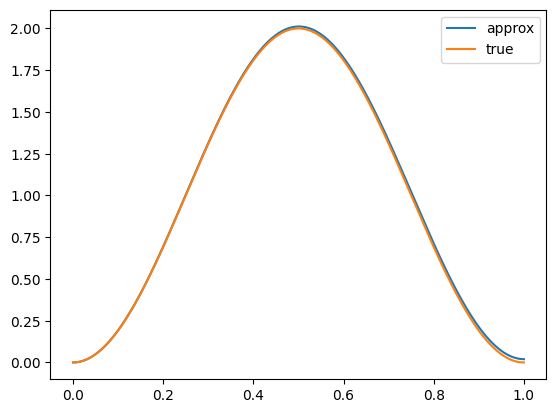

In [ ]:
from matplotlib import pyplot as plt

N = 1000
dx = 1./N

net = Net4(1,1,N,f,f_2)

x_p = torch.tensor(np.reshape(np.linspace(0,1,N),(N,1)),dtype=torch.float)
y_p = net.forward(x_p)

plt.plot(x_p.detach().numpy(),y_p.detach().numpy(),label='approx')
plt.plot(x_p.detach().numpy(),1-np.cos(2*np.pi*x_p.detach().numpy()),label='true')
plt.legend()

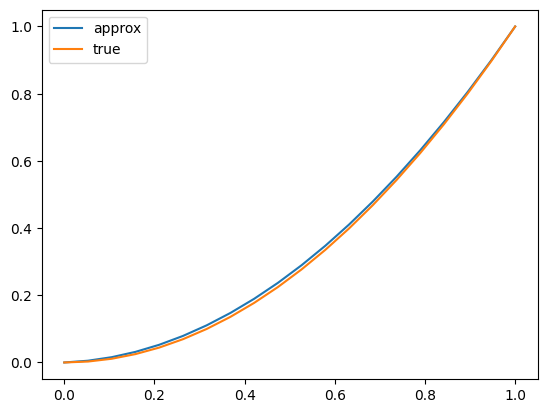

In [ ]:
N = 20
dx = 1./N

def x2(x):
  return x**2

def x2_2(x):
  return 2.

net = Net4(1,1,N,x2,x2_2) # the way the net is written is for interval [0,1]

x_p = torch.tensor(np.reshape(np.linspace(0,1,N),(N,1)),dtype=torch.float)
y_p = net.forward(x_p)

plt.plot(x_p.detach().numpy(),y_p.detach().numpy(),label='approx')
plt.plot(x_p.detach().numpy(),x_p.detach().numpy()**2,label='true')
plt.legend()


# Algorithm 6: Implementation of $x\to x^2$ using the architecture (1,3,...,3,1) with p hidden layers.

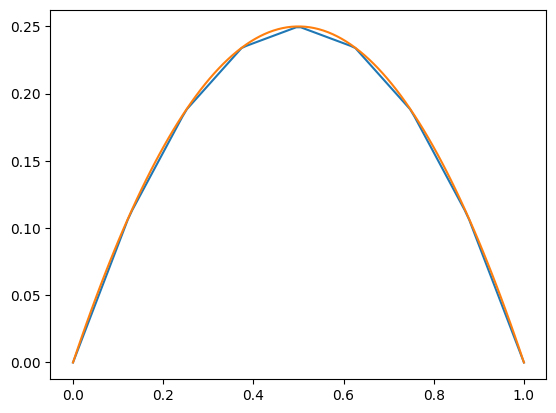

In [ ]:
fac = 4
depth = 2

class Net6(nn.Module):
    def __init__(self, nInput, nOutput, fac, depth):
        super(Net6, self).__init__()
        self.fac=fac
        self.depth = depth

        self.fc1 = nn.Linear(nInput, 3)
        with torch.no_grad():
          self.fc1.weight.copy_(self.init_W0())
          self.fc1.bias.copy_(self.init_b())

        self.fc2 = nn.Linear(3,3)
        with torch.no_grad():
          self.fc2.weight.copy_(self.init_W1())
          self.fc2.bias.copy_(self.init_b())

        self.fc3 = nn.Linear(3,3)
        with torch.no_grad():
          self.fc3.weight.copy_(self.init_W2())
          self.fc3.bias.copy_(self.init_b())

        self.fc4 = nn.Linear(3,1,bias=False)
        with torch.no_grad():
          self.fc4.weight.copy_(self.init_W3())

        self.Relu = nn.ReLU()

    def init_W0(self):
      return torch.tensor(np.reshape(np.array([1,1,0]),(3,1)))

    def init_b(self):
      return torch.tensor(np.array([0,-0.5,0]))

    def init_W1(self):
      return torch.tensor(np.transpose(np.array([[2,2,2/self.fac],[-4,-4,-4/self.fac],[0,0,1]])))

    def init_W2(self):
      return torch.tensor(np.transpose(np.array([[2,2,2/self.fac**2],[-4,-4,-4/self.fac**2],[0,0,1]])))

    def init_W3(self):
      return torch.tensor([2/self.fac**(self.depth+1),-4/self.fac**(self.depth+1),1])

    def forward(self, x):
        x = self.fc1(x)
        x = self.Relu(x)
        x = self.fc2(x)
        x = self.Relu(x)
        x = self.fc3(x)
        x = self.Relu(x)
        x = self.fc4(x)
        return x


net = Net6(1,1,fac,depth) # the way the net is written is for interval [0,1]
N = 100
x_p = torch.tensor(np.reshape(np.linspace(0,1,N),(N,1)),dtype=torch.float)
y_p = net.forward(x_p)

plt.plot(x_p.detach().numpy(),y_p.detach().numpy())
plt.plot(x_p.detach().numpy(),x_p.detach().numpy()*(1-x_p.detach().numpy()))


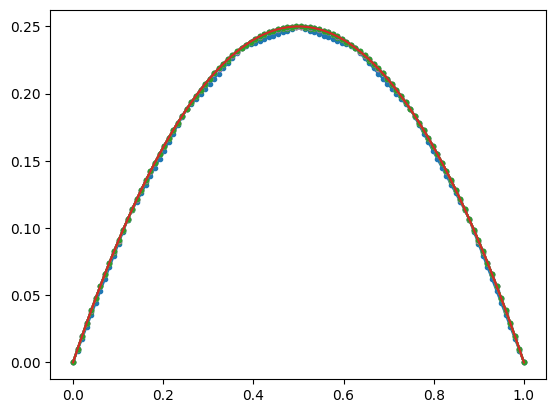

In [ ]:
# generalising to p layers

class Net6(nn.Module):
    def __init__(self, nInput, nOutput, fac, depth):
        super(Net6, self).__init__()
        self.fac=fac
        self.depth = depth

        self.fc1 = nn.Linear(nInput, 3)
        with torch.no_grad():
          self.fc1.weight.copy_(self.init_W0())
          self.fc1.bias.copy_(self.init_b())

        self.hidden_layers = []

        for i in range(self.depth):
          self.hidden_layers.append(nn.Linear(3,3))
          with torch.no_grad():
            self.hidden_layers[i].weight.copy_(self.init_W_hidden(i+1))
            self.hidden_layers[i].bias.copy_(self.init_b())

        self.fc_last = nn.Linear(3,1,bias=False)
        with torch.no_grad():
          self.fc_last.weight.copy_(self.init_W_last())

        self.Relu = nn.ReLU()

    def init_W0(self):
      return torch.tensor(np.reshape(np.array([1,1,0]),(3,1)))

    def init_b(self):
      return torch.tensor(np.array([0,-0.5,0]))

    def init_W_hidden(self,r):
      return torch.tensor(np.transpose(np.array([[2,2,2/self.fac**r],[-4,-4,-4/self.fac**r],[0,0,1]])))

    def init_W_last(self):
      return torch.tensor([2/self.fac**(self.depth+1),-4/self.fac**(self.depth+1),1])

    def forward(self, x):
        x = self.fc1(x)
        x = self.Relu(x)
        for i in range(self.depth):
          x = self.hidden_layers[i](x)
          x = self.Relu(x)

        x = self.fc_last(x)
        return x

errors = []
for depth in [2,3,4,5,6,7,8]:
  fac = 4

  net = Net6(1,1,fac,depth) # the way the net is written is for interval [0,1]
  N = 100
  x_p = torch.tensor(np.reshape(np.linspace(0,1,N),(N,1)),dtype=torch.float)
  y_p = net.forward(x_p)

  plt.plot(x_p.detach().numpy(),y_p.detach().numpy(),marker='.')
  plt.plot(x_p.detach().numpy(),x_p.detach().numpy()*(1-x_p.detach().numpy()))
  errors.append(np.linalg.norm(y_p.detach().numpy().flatten()-x_p.detach().numpy().flatten()*(1-x_p.detach().numpy().flatten()),np.inf))

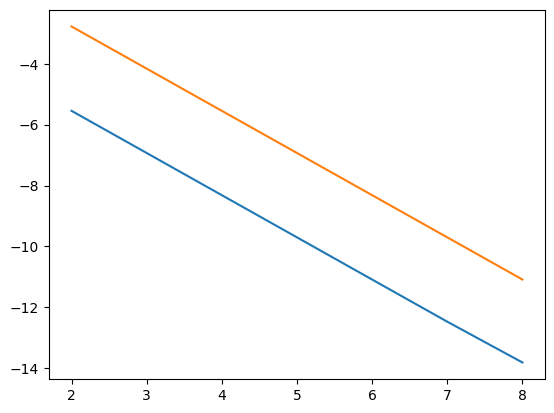

In [ ]:
true_error = [float(4**(-float(a))) for a in [2,3,4,5,6,7,8]]
plt.plot([2,3,4,5,6,7,8],np.log(errors))
plt.plot([2,3,4,5,6,7,8],np.log(true_error))

Do the same, but with a dataset and solving the minimisation problem:
$$ J(w) = \arg \min_w \sum_{i} \ell(f_w(x_i),y_i)$$

for $\ell$ the mean squared error, for example.

In [ ]:
# create dataset
from torch.utils.data import Dataset
import numpy as np
import torch

nData = 500
x_train = np.random.uniform(low=0.0, high=1, size=(nData,))
y_train = x_train*(1-x_train) #1-np.cos(2*np.pi*x_train)

x_test = np.sort(np.random.uniform(low=0.0, high=1.0, size=(50,)))

class CustomDataset(Dataset):
  def __init__(self, x,y):
        self.x = x
        self.y = y

  def __len__(self):
        return len(self.x)

  def __getitem__(self, idx):
        sample = {'x': self.x[idx], 'y': self.y[idx]}

        return sample

training_data = CustomDataset(x_train,y_train)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True, num_workers=2)


In [ ]:
class Net_learn(nn.Module):
    def __init__(self, nInput, nOutput, depth, nhidden):
        super(Net_learn, self).__init__()
        self.depth = depth
        self.nhidden = nhidden

        self.fc1 = nn.Linear(nInput, self.nhidden)

        self.hidden_layers = []

        for i in range(self.depth):
          self.hidden_layers.append(nn.Linear(self.nhidden,self.nhidden))

        self.fc_last = nn.Linear(self.nhidden,1,bias=False)
        self.Relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.Relu(x)
        for i in range(self.depth):
          x = self.hidden_layers[i](x)
          x = self.Relu(x)

        x = self.fc_last(x)
        return x








In [ ]:
model = Net_learn(1,1,4,100)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        data_size = data['x'].shape[0]
        inputs = data['x'].reshape((data_size,1))
        labels = data['y'].reshape((data_size,1))
        inputs = torch.tensor(inputs.clone().detach(),dtype=torch.float32)
        labels = torch.tensor(labels.clone().detach(),dtype=torch.float32)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
    #scheduler.step()
    print(running_loss)
    return last_loss



In [ ]:
for i in range(500):
  train_one_epoch(i)

0.21861495450139046


/tmp/ipython-input-2393762980.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(),dtype=torch.float32)
/tmp/ipython-input-2393762980.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(),dtype=torch.float32)


0.16822181083261967
0.12889999337494373
0.09865080937743187
0.07703418098390102
0.06279599945992231
0.05438656359910965
0.05009751161560416
0.047955341171473265
0.04681521514430642
0.046374852769076824
0.046380575746297836
0.04617290757596493
0.04593490809202194
0.045782951172441244
0.04574848897755146
0.045575257390737534
0.04540917044505477
0.04546678299084306
0.04540425119921565
0.04499152163043618
0.044948379043489695
0.044843682553619146
0.04470760142430663
0.044663842767477036
0.0444945297203958
0.04442194337025285
0.04428029200062156
0.04445986449718475
0.04406989412382245
0.04396364651620388
0.043915696907788515
0.04360158462077379
0.04340433329343796
0.04344318434596062
0.04331783624365926
0.04292984772473574
0.043010164052248
0.04248354397714138
0.0423684548586607
0.042047235649079084
0.04198203654959798
0.041585312224924564
0.041533687617629766
0.04110016208142042
0.04087014775723219
0.040500844828784466
0.04011569079011679
0.039998313412070274
0.039746795780956745
0.0393787

In [ ]:
y = model.forward(torch.reshape(torch.tensor(x_test,dtype=torch.float32),(50,1)))

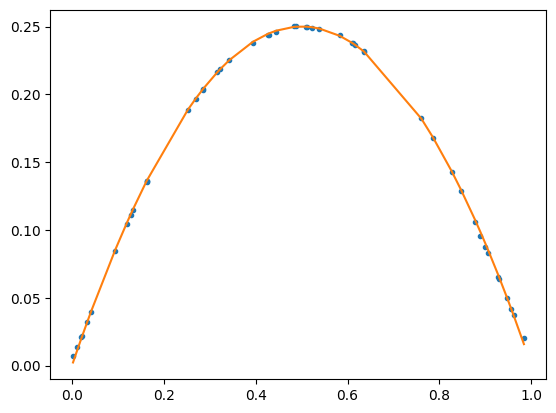

In [ ]:
plt.plot(x_test, y.detach().numpy(),ls='None',marker='.')
plt.plot(x_test, x_test*(1-x_test))
